<a href="https://colab.research.google.com/github/chen-star/llm_model_trainings/blob/main/5_2_fine_tuning_freeze_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> ⭐ Fine-tuning ⭐

---

Why freeze weights?

* Reduce the risk of overfitting with limited data.

* LLM can have a huge # of parameters, training entire model can be expensive.

* Generally speaking, early layers of TransformerBlocks learn low-level patterns while later layers tend to learn high-level features.  Freezing weights in early layers can preserve basic semantic patterns while training higher-level features.

---

# ✈ Imports

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

!pip install torchinfo
from torchinfo import summary

import requests
from typing import override

# 🔢 Hyperparameters

In [2]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
batch_size = 8

context_window_size = 512

# 📂 Prepare Training Data

In [ ]:
# import GPT-neo tokenizer
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125m')
tokenizer.pad_token_id = tokenizer.encode(' ')[0]

In [5]:
# download << 红楼梦 >>
text = requests.get('https://www.gutenberg.org/cache/epub/24264/pg24264.txt').text
token_ids = torch.tensor( tokenizer.encode(text),dtype=torch.long )
print(f'Token size: {len(token_ids)}')

Token indices sequence length is longer than the specified maximum sequence length for this model (2013214 > 2048). Running this sequence through the model will result in indexing errors


Token size: 2013214


# [0] 🏚 Model

In [ ]:
# import GPT-neo model
# one model to train full parameters
# another model to freeze some parameters
full_model = AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-125m').to(device)
freeze_model = AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-125m').to(device)

In [7]:
# inspect the before-fine-tuning model
freeze_model

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_fe

**Freeze Attention blocks in later layers**

In [8]:
for i in range(8, 12):
  for param in freeze_model.transformer.h[i].attn.attention.q_proj.parameters():
    param.requires_grad = False
  for param in freeze_model.transformer.h[i].attn.attention.k_proj.parameters():
    param.requires_grad = False
  for param in freeze_model.transformer.h[i].attn.attention.v_proj.parameters():
    param.requires_grad = False

# Verify that the parameters are frozen
print("Verifying frozen layers:")
for i in range(8, 12):
  q_frozen = all(not p.requires_grad for p in freeze_model.transformer.h[i].attn.attention.q_proj.parameters())
  k_frozen = all(not p.requires_grad for p in freeze_model.transformer.h[i].attn.attention.k_proj.parameters())
  v_frozen = all(not p.requires_grad for p in freeze_model.transformer.h[i].attn.attention.v_proj.parameters())
  print(f"Block {i}: q_proj frozen={q_frozen}, k_proj frozen={k_frozen}, v_proj frozen={v_frozen}")

Verifying frozen layers:
Block 8: q_proj frozen=True, k_proj frozen=True, v_proj frozen=True
Block 9: q_proj frozen=True, k_proj frozen=True, v_proj frozen=True
Block 10: q_proj frozen=True, k_proj frozen=True, v_proj frozen=True
Block 11: q_proj frozen=True, k_proj frozen=True, v_proj frozen=True


# [1] 🔘 Fine-tuning

In [9]:
# optimizers
full_optimizer = torch.optim.AdamW(full_model.parameters(), lr=5e-4, weight_decay=.01)
freeze_optimizer = torch.optim.AdamW(freeze_model.parameters(), lr=5e-4, weight_decay=.01)

In [11]:
# init losses
full_loss = []
freeze_loss = []

import time
# init training times
full_training_times = []
freeze_training_times = []

In [12]:
sample_size = 300

for i in range(sample_size):

  # get input data X
  random_idx = torch.randint(len(token_ids)-context_window_size, (batch_size,))
  X  = token_ids[random_idx[:,None] + torch.arange(context_window_size)].to(device)


  # ----- Fine-tuning `full_model` -----
  start_time_full = time.time()

  # clear previous gradients
  full_model.zero_grad(set_to_none=True)

  # forward
  # loss calc is handled in model internally
  outputs = full_model(X, labels=X)

  # back propagate
  outputs.loss.backward()
  full_optimizer.step()

  # save loss
  full_loss.append(outputs.loss.item())
  end_time_full = time.time()
  full_training_times.append(end_time_full - start_time_full)
  # ----------------------------------------------------------------------



  # ----- Fine-tuning `freeze_model` -----
  start_time_freeze = time.time()

  # clear previous gradients
  freeze_model.zero_grad(set_to_none=True)

  # forward
  # loss calc is handled in model internally
  outputs = freeze_model(X, labels=X)

  # back propagate
  outputs.loss.backward()
  freeze_optimizer.step()

  # save loss
  freeze_loss.append(outputs.loss.item())
  end_time_freeze = time.time()
  freeze_training_times.append(end_time_freeze - start_time_freeze)
  # ------------------------------------------------------------------

  # print progress
  if i % 50 == 0:
    print(f"Iteration {i}/{sample_size}: Full Model Loss = {full_loss[-1]:.4f}, Freeze Model Loss = {freeze_loss[-1]:.4f}")


# Print total training times
full_training_time_total = sum(full_training_times)
freeze_training_time_total = sum(freeze_training_times)
print(f"\nTotal training time for Full Model: {full_training_time_total:.2f} seconds")
print(f"Total training time for Freeze Model: {freeze_training_time_total:.2f} seconds")

Iteration 0/300: Full Model Loss = 2.6975, Freeze Model Loss = 2.6975
Iteration 50/300: Full Model Loss = 2.1265, Freeze Model Loss = 2.1231
Iteration 100/300: Full Model Loss = 2.0595, Freeze Model Loss = 2.0555
Iteration 150/300: Full Model Loss = 1.9437, Freeze Model Loss = 1.9325
Iteration 200/300: Full Model Loss = 1.9302, Freeze Model Loss = 1.9286
Iteration 250/300: Full Model Loss = 1.9408, Freeze Model Loss = 2.9067

Total training time for Full Model: 347.64 seconds
Total training time for Freeze Model: 342.11 seconds


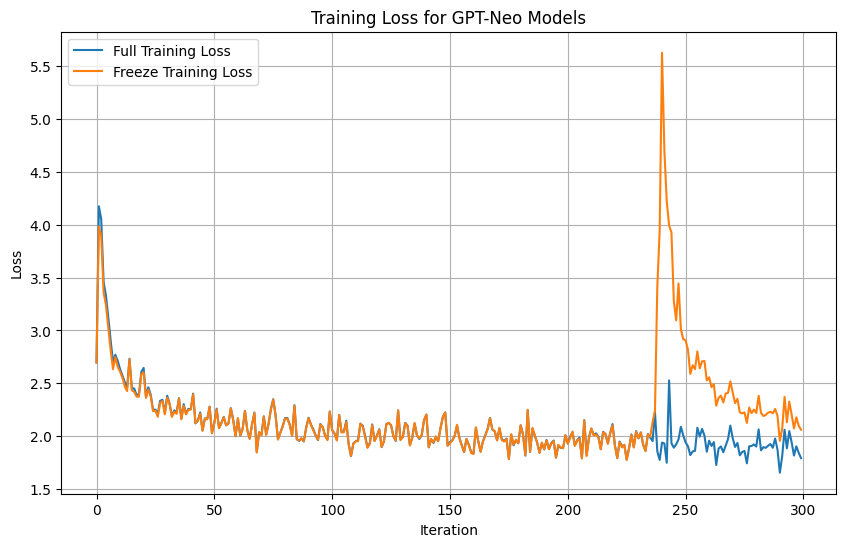

In [13]:
# plot the losses
plt.figure(figsize=(10, 6))
plt.plot(full_loss, label='Full Training Loss')
plt.plot(freeze_loss, label='Freeze Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss for GPT-Neo Models')
plt.legend()
plt.grid(True)
plt.show()

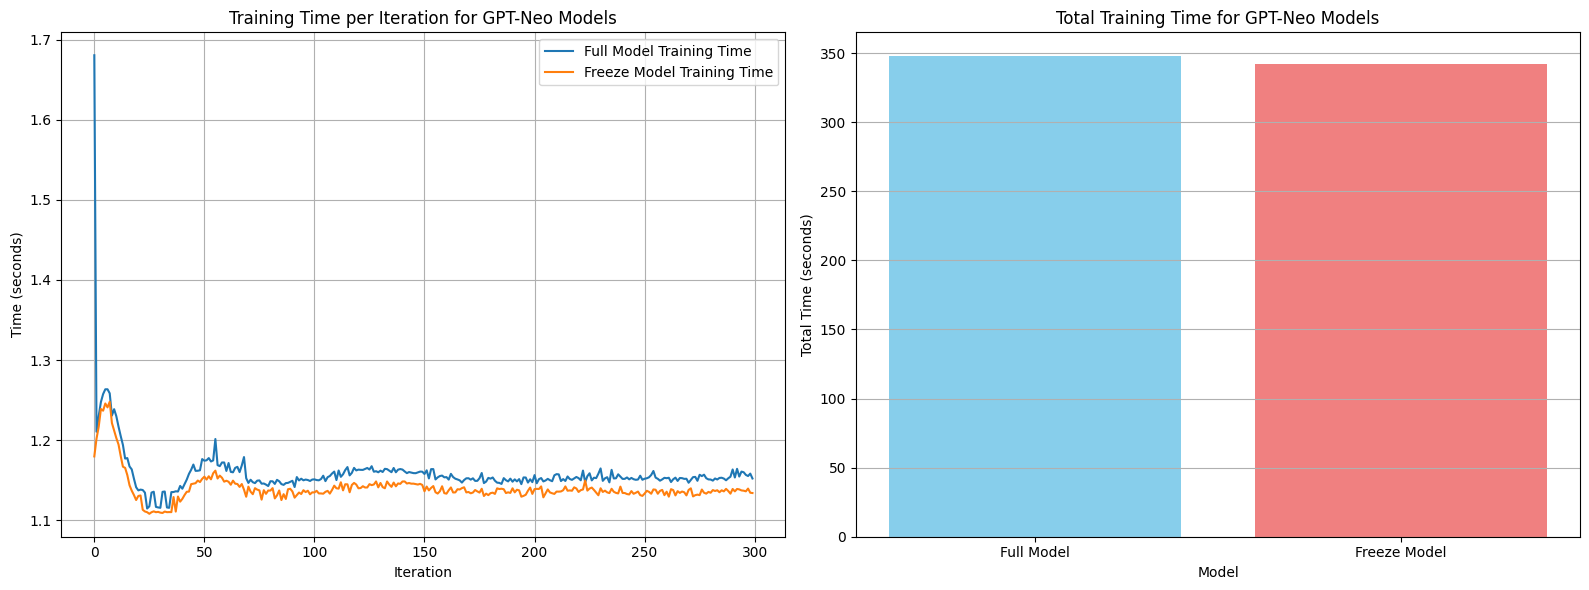

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Training Time per Iteration
ax1.plot(full_training_times, label='Full Model Training Time')
ax1.plot(freeze_training_times, label='Freeze Model Training Time')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Training Time per Iteration for GPT-Neo Models')
ax1.legend()
ax1.grid(True)

# Subplot 2: Total Training Time
models = ['Full Model', 'Freeze Model']
total_times = [full_training_time_total, freeze_training_time_total]
ax2.bar(models, total_times, color=['skyblue', 'lightcoral'])
ax2.set_xlabel('Model')
ax2.set_ylabel('Total Time (seconds)')
ax2.set_title('Total Training Time for GPT-Neo Models')
ax2.grid(axis='y')

plt.tight_layout()
plt.show()

# [2] 🧪 Evaluation of Fine-tuned models

### Quanlitative

Given a same prompt, generate text...

In [16]:
# Qualitative
prompt = "你好，我是贾宝玉。"
print()

print('--- Generating text from Full model ---')
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
output = full_model.generate(input_ids, max_length=200, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, temperature=0.7)
print(tokenizer.decode(output[0], skip_special_tokens=True))

print('\n--- Generating text from Freeze model ---')
output = freeze_model.generate(input_ids, max_length=200, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, temperature=0.7)
print(tokenizer.decode(output[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Generating text from Full model ---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


你好，我是贾宝玉。”寶玉笑道：“我也不喝，
但不知道了．你不知道，我也不知道，但只是什么事？"一輩子道：“這個是
老太太的們，我到了他們做什么？"寶玉笑道：“我只怕老太太們，若是這
個

--- Generating text from Freeze model ---
你好，我是贾宝玉。”寶玉因了，便笑道：“我別他們罷，倒
罷。”寶玉起來，便便走道：“把你們也們的，我們這個罷．你這
個里趣，你們沒有些個我們，我們是我們的？"起來一�


#### Quantitative: Perplexity

Perplexity is a measure of how well a probability distribution or language model predicts a sample. A lower perplexity score indicates that the model is better at predicting the next word in a sequence, given the previous words.

In simpler terms, a lower perplexity means the model is more confident and accurate in its predictions, making it a better language model for the given text.

In [17]:
# Prepare train / test dataset

split_ratio = 0.8 # 80% for training, 20% for validation

# Split token IDs
split_idx = int(len(token_ids) * split_ratio)
train_ids = token_ids[:split_idx]
test_ids = token_ids[split_idx:]

print(f"train set size: {len(train_ids)}")
print(f"validation set size: {len(test_ids)}")
print(f"train / test: {len(train_ids) / len(test_ids)}")

train set size: 1610571
validation set size: 402643
train / test: 3.999997516410319


In [18]:
# Perplexity is calculated as: PPL = exp(cross_entropy_loss)

def calculate_perplexity(model, tokenized_text_data, batch_size, context_window_size, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    num_batches = 0

    # Iterate through the tokenized text data in batches
    # The last batch might be smaller than context_window_size, so handle it.
    # We need at least context_window_size + 1 tokens for input and label
    # because labels are shifted internally in CausalLM models.
    for i in range(0, len(tokenized_text_data) - context_window_size -1, batch_size):
        batch_end = i + batch_size
        # Ensure we don't go out of bounds and have enough data for context_window_size
        if batch_end * context_window_size > len(tokenized_text_data):
            break # Stop if we can't form a full batch of context_window_size

        # Create input tensors for the current batch
        # We need to extract context_window_size tokens for each sample in the batch
        batch_input_ids = []
        for j in range(batch_size):
            start_idx = i + j * context_window_size
            end_idx = start_idx + context_window_size
            if end_idx > len(tokenized_text_data):
                break
            batch_input_ids.append(tokenized_text_data[start_idx:end_idx])

        if not batch_input_ids: # If no full segments could be formed for this batch
            break

        input_ids = torch.stack(batch_input_ids).to(device)

        with torch.no_grad():  # Disable gradient calculations
            outputs = model(input_ids, labels=input_ids) # Labels are the same as input for CausalLM
            # Internally, CausalLM models calculate cross-entropy loss by comparing
            # the predicted logits for the next token against the actual next token (from labels).
            # The `labels` are shifted inside the model so that `labels[i]` is used as the target for `logits[i]`.
            # The loss is then averaged over the sequence and batch.
            loss = outputs.loss
            total_loss += loss.item()
            num_batches += 1

    if num_batches == 0:
        return float('inf') # Return infinity if no batches were processed

    average_loss = total_loss / num_batches
    perplexity = torch.exp(torch.tensor(average_loss))
    return perplexity.item()

Calculate perplexity for both models...

In [19]:
full_model_perplexity = calculate_perplexity(
    full_model,
    test_ids,
    batch_size,
    context_window_size,
    device
)
print(f"Full model perplexity on validation set: {full_model_perplexity:.2f}")

Full model perplexity on validation set: 6.17


In [20]:
freeze_model_perplexity = calculate_perplexity(
    freeze_model,
    test_ids,
    batch_size,
    context_window_size,
    device
)
print(f"Freeze model perplexity on validation set: {freeze_model_perplexity:.2f}")

Freeze model perplexity on validation set: 7.72
